In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# This will reload imports before executing code, allowing you to easily change contents of custom scripts
%load_ext autoreload
%autoreload 2

# Stay classification: cluster-splitting with box-refinement & shifting boxes

## Current evaluation

### Pros
* can separate sequence and identify rudimentary clusters

### Cons
* can't distinguish stays from travels 
    * nothing created to do so.

## ToDos

* check that the newly split clusters are 
    * contain enough samples
    * have a total duration longer than the threshold
    * are not embedded within another cluster
* check that there are no embedded clusters
    * times don't overlap $\checkmark\to$ have function
    * if refined clusters are embedded, check if one cluster is noise
* check the stddev of the refined clusters are smaller
* check on the limits of time between adjacent clusters, esp. when they have the same mean and/or median
    * if at $x_a$ for $t_1$ then again at $x_a$ for $t_2$, duration between going from and back to $x_a$ should reflect some mimimal amount of time ($2\times$ travel and a stay), 
        * e.g. 
            * from $x_a$ to an unknown $x_b$ with a stay at $x_b$ of the miminum duration and then back to $x_a$ 
            * should satisfy some criterion or _there is no inbetween travel and $t_1$ and $t_2$ are part of the same cluster_
* check of the metrics for inter-subcluster gaps
    * these are also clusters but unlabeled after the first round of clustering

## Notes: 

* **Gaps** 
    * since there are subclusters for a given cluster which are separated by gaps, these gaps ...

### 1-stay
* gap-merging works well when good density; poorly when otherwise

## Future directions

It may be best to use this as an initial pass for the box, or _any_, method, thereby confining the errors and speeding up the compute.



In [3]:
import numpy as np
import pandas as pd

In [4]:
import os, sys
sys.path.append('/home/sandm/Notebooks/stay_classification/src/')

In [5]:
# #############################################################################
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, 10)]

from random import shuffle

In [7]:
shuffle(colors)

# Sythetic data

In [8]:
from synthetic_data.trajectory import get_stay_segs, get_adjusted_stays
from synthetic_data.trajectory_class import get_rand_traj
from synthetic_data.plotting import plot_trajectory, add_plot_seg_boxes

from synthetic_data.trajectory_class import get_trajectory
from synthetic_data.trajectory import get_stay

dsec = 1/3600.0
t_total = np.arange(0,24,dsec)

In [9]:
from synthetic_data.canonical_stays import get1, get2, get3e, get3, get3_core, gen_stays

In [10]:
from stay_classification.splitting_classifier.splitting_classifier import get_clusters

In [11]:
from helper__metric_box__explore import iqr_metrics, get_boxplot_quants, get_clusters_rev, get_boxplot_centers, get_iqr_mask

In [12]:
get_2_stays = lambda n: 11.4*np.random.rand(n) - 5.7

# Clustering

## Split the clusters which have a temporal gap

### IQR-plotting

For each sub-cluster, plot the quantile boxes with whistkers.

**Notes**
* the boxes usually capture the baseline of the underlying stay
* the forward and backward clusters
    * usually the same clusters in the stays with similar IQRs
    * usually different in the 

In [13]:
from helper__3stays_v3_scripts import get_clusters_x

In [91]:
event_frac = 0.01 #rand_range(1,0.01,0.001)[0]
duplicate_frac = 0.0 #rand_range(1,0.3,0.05)[0]

configs = {
    'time_thresh':1/6,
    'dist_thresh':0.5,
    'event_frac':event_frac,
    'duplicate_frac':duplicate_frac,    
    'noise_min':0.02,
    'noise_max':0.15
}

stays = get3(2, 1)
#stays = get1()

In [92]:
time_thresh = 1/6
dist_thresh=0.25

In [93]:
time_arr, raw_arr, noise_arr, segments = get_trajectory(stays, t_total, configs)
t_segs, x_segs = get_stay_segs(get_adjusted_stays(segments, time_arr))

clusters = get_clusters_x(time_arr, noise_arr, dist_thresh, time_thresh)
print(len(clusters))

clusters_rev = get_clusters_x(time_arr[::-1], noise_arr[::-1], dist_thresh, time_thresh)
print(len(clusters_rev))

'''plt.figure(figsize=(20,10))
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);''';

7
6


In [94]:
from helper__3stays_v3_scripts import plot_cluster_boxplots

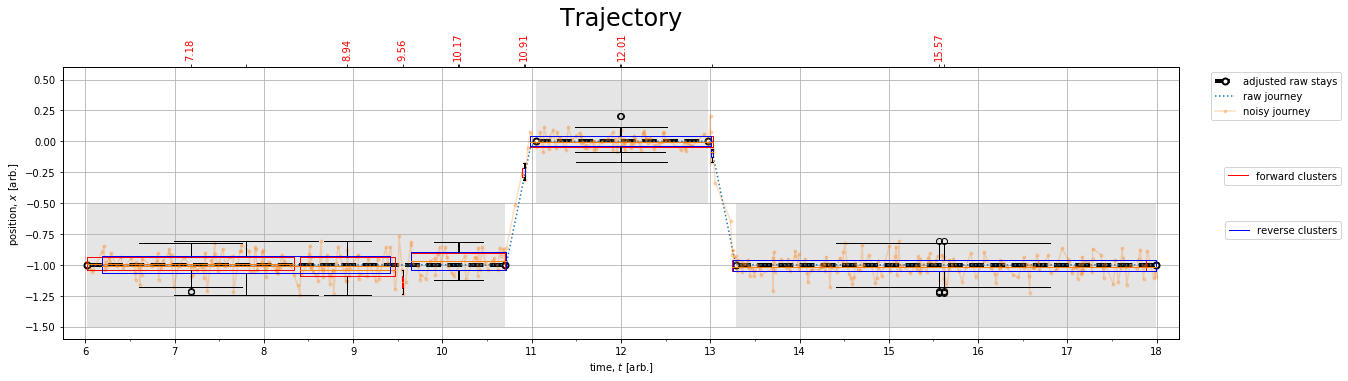

In [95]:
ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, clusters, clusters_rev, configs);

In [19]:
from helper__metric_box__explore import eval_synth_data

In [20]:
#flatten = lambda l: [item for sublist in l for item in sublist]
time_arr.size, len([item for cluster in clusters for item in cluster]), time_arr.size-len([item for cluster in clusters for item in cluster])

(432, 417, 15)

In [21]:
prec, rec, conmat = eval_synth_data(segments, time_arr, clusters)
print('forward')
print(f"{prec:6.3f}")
print(f"{ rec:6.3f}")
print(conmat)
print()
prec, rec, conmat = eval_synth_data(segments, time_arr, clusters_rev)
print('backward')
print(f"{prec:6.3f}")
print(f"{ rec:6.3f}")
print(conmat)

forward
 0.993
 0.972
[[  3   3]
 [ 12 414]]

backward
 0.988
 0.969
[[  1   5]
 [ 13 413]]


## Development

In [22]:
from helper__gaps import merge_clusters

In [23]:
from helper__metric_box__explore import get_cluster_boxplot, kwargs_filled, kwargs_unfilled

### Early gap-method

3
3


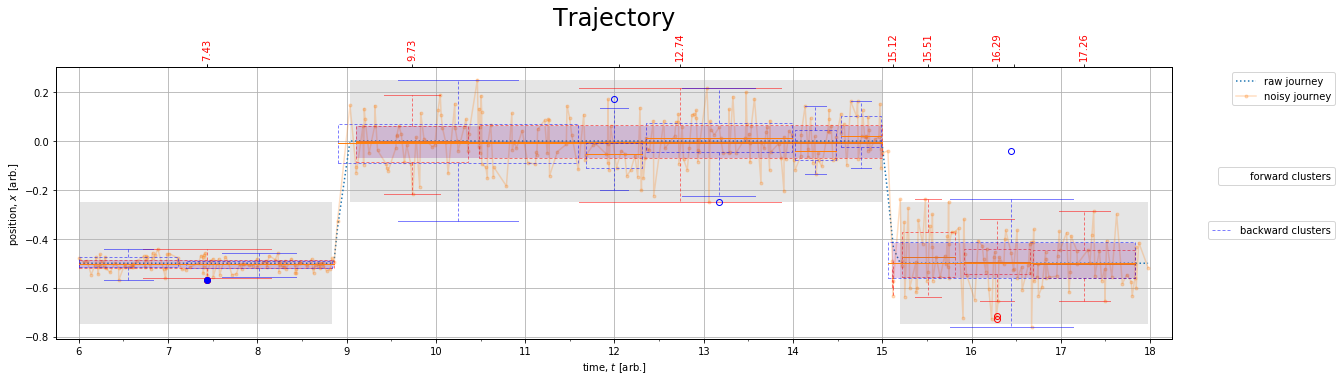

In [24]:
ax = plot_trajectory(time_arr, raw_arr, noise_arr, None, None, configs['dist_thresh']);
add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)

ax.set_xlim([5.75,18.25])

axt = ax.twiny()

kwargs_unfilled['color'] = 'red'
kwargs_unfilled['legend_label'] = 'forward clusters'
kwargs_unfilled['bbox_tuple'] = (1.15, 0.6)

kwargs_filled['color'] = 'red'
kwargs_filled['legend_label'] = None
kwargs_filled['bbox_tuple'] = (1.15, 0.6)



new_clusters = merge_clusters(time_arr, noise_arr, clusters, dist_thresh, time_thresh)
print(len(new_clusters))
axt = get_cluster_boxplot(new_clusters, time_arr, noise_arr, axt, **kwargs_filled)

axt = get_cluster_boxplot(clusters, time_arr, noise_arr, axt, **kwargs_unfilled)
_, labels, _, _ = get_boxplot_quants(time_arr, noise_arr, clusters)
for label in axt.get_xticklabels():
    label.set_rotation(90)
axt.set_xticklabels(labels, visible=True, color='red')
axt.set_xlim(ax.get_xlim())


axt = ax.twiny()

kwargs_unfilled['color'] = 'blue'
kwargs_unfilled['legend_label'] = 'backward clusters'
kwargs_unfilled['bbox_tuple'] = (1.15, 0.4)

kwargs_filled['color'] = 'blue'
kwargs_filled['legend_label'] = None
kwargs_filled['bbox_tuple'] = (1.15, 0.4)

axt = get_cluster_boxplot(clusters_rev, time_arr, noise_arr, axt, **kwargs_unfilled)
_, labels, _, _ = get_boxplot_quants(time_arr[::-1], noise_arr[::-1], clusters_rev)

new_clusters_rev = merge_clusters(time_arr, noise_arr, clusters, dist_thresh, time_thresh)
print(len(new_clusters_rev))
axt = get_cluster_boxplot(new_clusters_rev, time_arr, noise_arr, axt, **kwargs_filled)

for label in axt.get_xticklabels():
    label.set_rotation(90)    
axt.set_xticklabels(labels, visible=False)
axt.set_xlim(ax.get_xlim())


ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1);

In [25]:
prec, rec, conmat = eval_synth_data(segments, time_arr, new_clusters)
print('forward')
print(f"{prec:6.3f}")
print(f"{ rec:6.3f}")
print(conmat)
print()
prec, rec, conmat = eval_synth_data(segments, time_arr, new_clusters_rev)
print('backward')
print(f"{prec:6.3f}")
print(f"{ rec:6.3f}")
print(conmat)

forward
 0.991
 0.988
[[  2   4]
 [  5 421]]

backward
 0.991
 0.988
[[  2   4]
 [  5 421]]


### Later gap method

In [26]:
from helper__gaps import get_intercluster_metrics

In [27]:
for c1,c2 in zip(clusters[:-1],clusters[1:]):
    
    gap_time, min_allowed, x_med = get_intercluster_metrics(c1, c2, time_arr, noise_arr, time_thresh, 3.4)
    
    print(f"{gap_time:5.3f}, {min_allowed:5.3f}", 
          gap_time < min_allowed, 
          f"\t{np.median(noise_arr[c1]):7.3f} {x_med:7.3f} {np.median(noise_arr[c2]):7.3f}", 
          f"\t{abs(np.median(noise_arr[c1])-x_med):7.3f} {abs(np.median(noise_arr[c2])-x_med):7.3f}")

0.243, 0.315 True 	 -0.504  -0.217  -0.000 	  0.287   0.217
0.118, 0.170 True 	 -0.000   0.003  -0.006 	  0.003   0.009
0.120, 0.330 True 	 -0.006  -0.050  -0.561 	  0.043   0.511
0.099, 0.192 True 	 -0.561  -0.531  -0.476 	  0.030   0.056
0.103, 0.238 True 	 -0.476  -0.365  -0.497 	  0.110   0.132
0.033, 0.181 True 	 -0.497  -0.477  -0.504 	  0.020   0.028


In [28]:
from helper__gaps import merge_cluster_pair, gap_criterion_2, merge_clusters_2

3
3


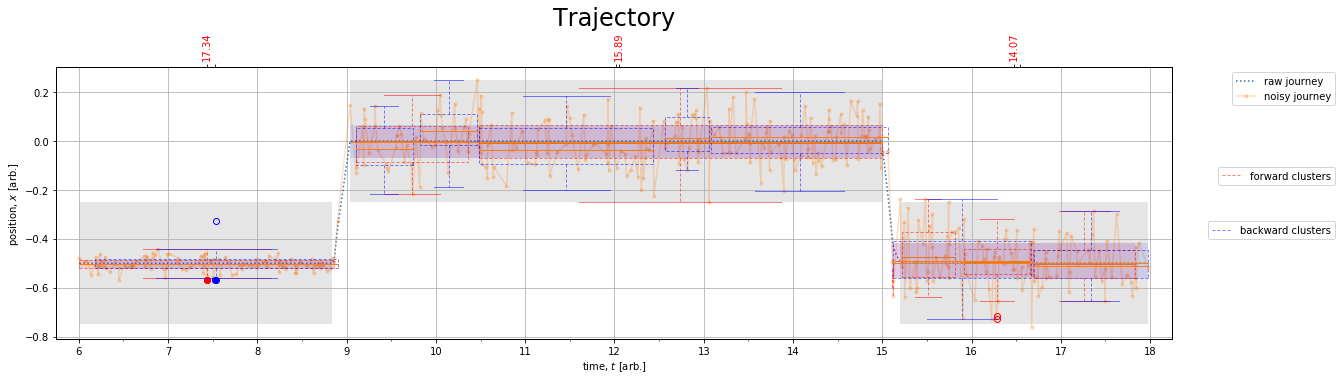

In [29]:
ax = plot_trajectory(time_arr, raw_arr, noise_arr, None, None, configs['dist_thresh']);
add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)

ax.set_xlim([5.75,18.25])

axt = ax.twiny()

kwargs_unfilled['color'] = 'red'
kwargs_unfilled['legend_label'] = 'forward clusters'
kwargs_unfilled['bbox_tuple'] = (1.15, 0.6)

kwargs_filled['color'] = 'red'
kwargs_filled['legend_label'] = None
kwargs_filled['bbox_tuple'] = (1.15, 0.6)

axt = get_cluster_boxplot(clusters, time_arr, noise_arr, axt, **kwargs_unfilled)

new_clusters_2 = merge_clusters_2(time_arr, noise_arr, clusters, dist_thresh, time_thresh)
print(len(new_clusters_2))
axt = get_cluster_boxplot(new_clusters_2, time_arr, noise_arr, axt, **kwargs_filled)

for label in axt.get_xticklabels():
    label.set_rotation(90)
axt.set_xticklabels(labels, visible=True, color='red')
axt.set_xlim(ax.get_xlim())


axt = ax.twiny()

kwargs_unfilled['color'] = 'blue'
kwargs_unfilled['legend_label'] = 'backward clusters'
kwargs_unfilled['bbox_tuple'] = (1.15, 0.4)

kwargs_filled['color'] = 'blue'
kwargs_filled['legend_label'] = None
kwargs_filled['bbox_tuple'] = (1.15, 0.4)

axt = get_cluster_boxplot(clusters_rev, time_arr[::-1], noise_arr[::-1], axt, **kwargs_unfilled)
new_clusters_rev_2 = merge_clusters_2(time_arr[::-1], noise_arr[::-1], clusters, dist_thresh, time_thresh)
print(len(new_clusters_rev_2))
axt = get_cluster_boxplot(new_clusters_rev_2, time_arr[::-1], noise_arr[::-1], axt, **kwargs_filled)

for label in axt.get_xticklabels():
    label.set_rotation(90)    
axt.set_xticklabels(labels, visible=False)
axt.set_xlim(ax.get_xlim())


ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1);

In [30]:
from helper__metric_box__explore import iqr_metrics, get_iqr, get_iqr_mask

In [31]:
total_indices = []
for c in new_clusters_2:
    total_indices.extend(c)

In [32]:
total_indices_rev = []
for c in new_clusters_rev_2:
    total_indices_rev.extend(list(set(c).intersection(set(total_indices))))
total_indices_rev = sorted(total_indices_rev)

In [33]:
total_mindices = []
for c in new_clusters_2:
    mask = get_iqr_mask(noise_arr[c], c, 0, True)
    total_mindices.extend(mask[0].tolist())

In [34]:
total_mindices_rev = []
final_clusters = []
for c in new_clusters_rev_2:
    mask = get_iqr_mask(noise_arr[c], c, 0, True)
    cluster = list(set(mask[0].tolist()).intersection(set(total_mindices)))
    total_mindices_rev.extend(cluster)
    final_clusters.append(sorted(cluster))
total_mindices_rev = sorted(total_mindices_rev)

In [35]:
time_arr.size, len(total_indices),  len(total_mindices), len(total_indices_rev), len(total_mindices_rev)

(432, 425, 209, 425, 209)

(5.5, 18.25)

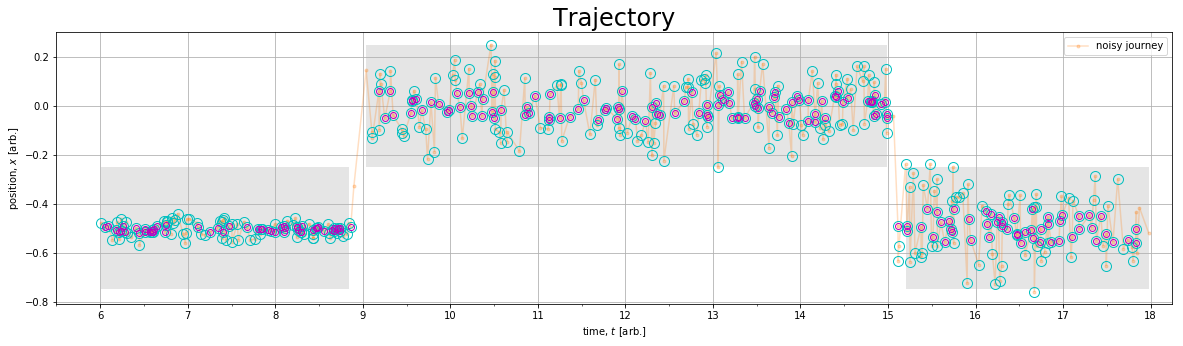

In [36]:
ax = plot_trajectory(time_arr, None, noise_arr, None, None, configs['dist_thresh']);
add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)

ax.plot(time_arr[total_indices], noise_arr[total_indices], "co", markersize=10, markerfacecolor='None')
ax.plot(time_arr[total_mindices_rev], noise_arr[total_mindices_rev], "mo", markersize=6, markerfacecolor='None')

ax.set_xlim([5.5,18.25])
#ax.set_xlim([8.5,15.5]);

### From here

At this point, it seems that the basic clusters are formed. 

Next, use the IQRs of these clusters as the new bounds for extending the cluster: essentially using the extensible box method.

Note that the IQR can be larger than the allow distance threshold; the box would therefore need to be the smaller of the two but with the same mean and/or median

In [37]:
final_cluster = []
for c in final_clusters:
    final_cluster.extend(c)

print(len(final_cluster))

209


In [38]:
for n in range(3):
    print(f"{time_arr[final_clusters[n][0]]:7.4f}",
         f"{t_segs[3*n]:7.4f}", 
         f"{time_arr[final_clusters[n][-1]]:7.4f}",
         f"{t_segs[3*n+1]:7.4f}")

 6.0569  6.0069  8.8614  8.8386
 9.1828  9.0378 14.9939 14.9939
15.1136 15.2008 17.8308 17.9769


(5.5, 18.25)

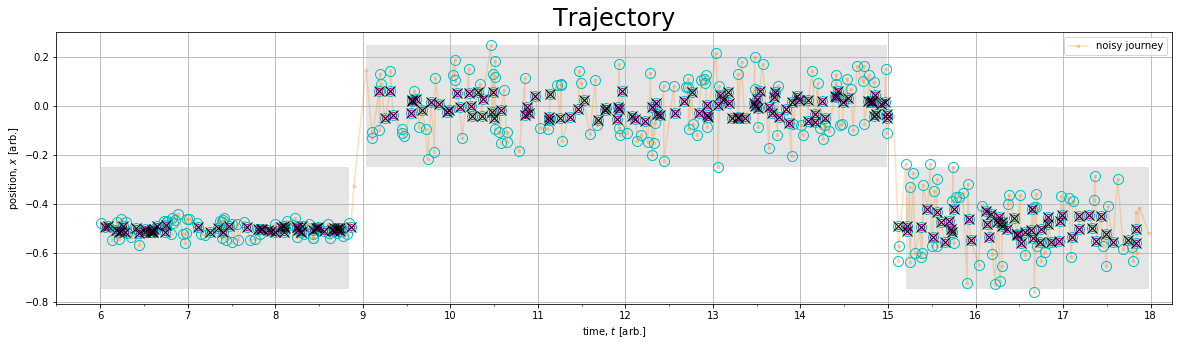

In [39]:
ax = plot_trajectory(time_arr, None, noise_arr, None, None, configs['dist_thresh']);
add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)

ax.plot(time_arr[total_indices], noise_arr[total_indices], "co", markersize=10, markerfacecolor='None')
ax.plot(time_arr[total_mindices_rev], noise_arr[total_mindices_rev], "mo", markersize=6, markerfacecolor='None')
ax.plot(time_arr[final_cluster], noise_arr[final_cluster], "kx", markersize=10, markerfacecolor='None')

ax.set_xlim([5.5,18.25])
#ax.set_xlim([8.5,15.5]);

In [40]:
from helper__3stays_v3_scripts import extend_cluster, intersecting_bounds, extend_final_clusters

In [41]:
from helper__3stays_v3_scripts import _extend_edge, get_iqr_mask_x, get_bounded_events

In [42]:
from stay_classification.box_classifier.box_method import get_time_ind
#get_mask, make_box, get_directional_indices, get_thresh_mean, check_means, 

(-0.5178085564437694, -0.4866694659480644)
1 109 1 109
(-0.06755297672536559, 0.06073286449465082)
(-0.06755297672536559, 0.06073286449465082)
114 320 114 321
(-0.5604926206352833, -0.4199297054579391)
(-0.5604926206352833, -0.4199297054579391)
322 427 322 428


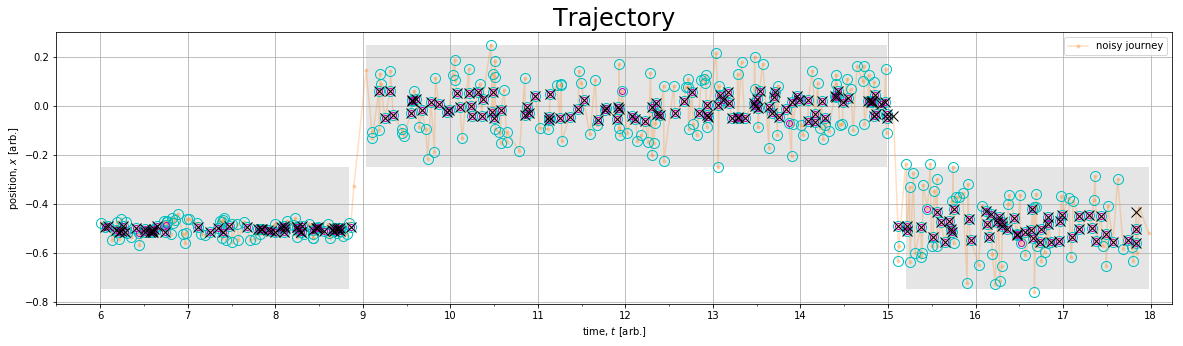

In [43]:
ax = plot_trajectory(time_arr, None, noise_arr, None, None, configs['dist_thresh']);
add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)

ax.plot(time_arr[total_indices], noise_arr[total_indices], "co", markersize=10, markerfacecolor='None')
ax.plot(time_arr[total_mindices_rev], noise_arr[total_mindices_rev], "mo", markersize=6, markerfacecolor='None')

ax.set_xlim([5.5,18.25])
#ax.set_xlim([8.5,15.5]);

for c in final_clusters:

    new_end = get_time_ind(time_arr,time_arr[c[-1]], time_thresh, 1)

    last_ind = c[-1]
    keep_going = True
    while keep_going:
        
        cc = get_iqr_mask_x(noise_arr[c[0]:new_end], c[0], (noise_arr[c].min(), noise_arr[c].max()), 0, True)[0]        
        
        if cc[-1]!=last_ind:
            last_ind = cc[-1]
        else:
            break

        new_end = get_time_ind(time_arr,time_arr[new_end], 2*time_thresh, 1)
            
    
    ax.plot(time_arr[cc], noise_arr[cc], "kx", markersize=10, markerfacecolor='None')
            
    print(c[0], c[-1], cc[0], cc[-1])

In [44]:
from helper__metric_box__explore import extend_cluster, extend_clusters, extend_edge

(-0.5178085564437694, -0.4866694659480644)
Backwards
1 109 0
(-0.5178085564437694, -0.4866694659480644)
1 1 0 1

1 1 0

Forwards
1 109 115
(-0.5178085564437694, -0.4866694659480644)
1 109 115 109
1 109 115

(-0.06755297672536559, 0.06073286449465082)
Backwards
114 320 109
(-0.06755297672536559, 0.06073286449465082)
114 114 109 114

114 114 109

Forwards
114 320 331
(-0.06755297672536559, 0.06073286449465082)
114 321 331 320
not = 114 321 331 320
(-0.06755297672536559, 0.06073286449465082)
114 321 334 321
114 321 334

(-0.5604926206352833, -0.4199297054579391)
Backwards
322 427 308
(-0.5604926206352833, -0.4199297054579391)
322 322 308 322

322 322 308

Forwards
322 427 431
(-0.5604926206352833, -0.4199297054579391)
322 428 431 427
not = 322 428 431 427
(-0.5604926206352833, -0.4199297054579391)
322 428 431 428
322 428 431



(5.5, 18.25)

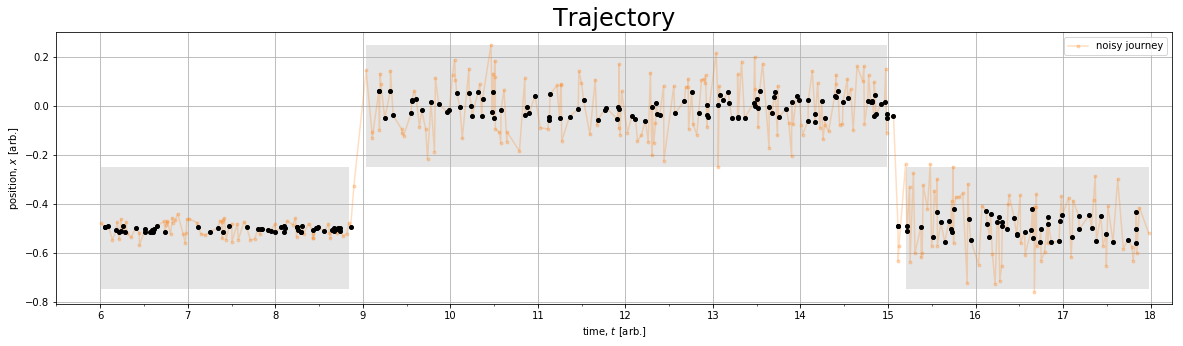

In [45]:
ax = plot_trajectory(time_arr, None, noise_arr, None, None, configs['dist_thresh']);
add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)

finals_index = 2

final_extended_clusters = []

for c in final_clusters:

    #ax.plot(time_arr[c], noise_arr[c], "co", markersize=14, markerfacecolor='None')
    
    # Get cluster
    #c = final_clusters[finals_index]

    print((noise_arr[c].min(), noise_arr[c].max()))

    # extend time forwards
    print("Backwards")

    new_end = get_time_ind(time_arr, time_arr[c[0]], 2*time_thresh, -1)
    print(c[0],c[-1],new_end)

    last_ind = c[0]
    keep_going = True
    while keep_going:

        cc = get_iqr_mask_x(noise_arr[new_end:c[1]], new_end, (noise_arr[c].min(), noise_arr[c].max()), 0, True)[0]        
        print(cc[0], cc[-1], new_end, last_ind)

        extended_cluster_ = cc.copy()
        if cc[0] != last_ind:
            print("not = ", cc[0], cc[-1], new_end, last_ind)
            last_ind = cc[0]
        else:
            break

        new_end = get_time_ind(time_arr, time_arr[last_ind], 2*time_thresh, -1)

    print()

    print(extended_cluster_[0], extended_cluster_[-1], new_end)

    print()

    #noise_arr[c[0]:new_end]
    #ax.plot(time_arr[c[0]:new_end], noise_arr[c[0]:new_end], "mo", markersize=10, markerfacecolor='None')

    #ax.plot(time_arr[extended_cluster_], noise_arr[extended_cluster_], "k+", markersize=10, markerfacecolor='None')


    #ccc = get_bounded_events(noise_arr[c[0]:new_end], c, noise_arr[c].min(), noise_arr[c].max())

    #print("this",_get_iqr(noise_arr[c]))
    #print(ccc[0],ccc[-1])

    if cc[-1]!=last_ind:
        last_ind = cc[-1]

    new_end = get_time_ind(time_arr,time_arr[new_end], 2*time_thresh, 1)


    #ccc = get_bounded_events(noise_arr[cc], cc, noise_arr[cc].min(), noise_arr[cc].max())
        
    
    
    # extend time forwards
    print("Forwards")

    new_end = get_time_ind(time_arr,time_arr[c[-1]], 2*time_thresh, 1)
    print(c[0],c[-1],new_end)

    last_ind = c[-1]
    keep_going = True
    while keep_going:

        cc = get_iqr_mask_x(noise_arr[c[0]:new_end], c[0], (noise_arr[c].min(), noise_arr[c].max()), 0, True)[0]        
        print(cc[0],cc[-1],new_end, last_ind)
        extended_cluster = cc.copy()
        if cc[-1] != last_ind:
            print("not =", cc[0],cc[-1],new_end, last_ind)
            last_ind = cc[-1]
        else:
            break

        new_end = get_time_ind(time_arr, time_arr[last_ind], 2*time_thresh, 1)

    print(extended_cluster[0],extended_cluster[-1],new_end)
    
    #final_extended_clusters = extended_cluster.copy()
    print()

    #noise_arr[c[0]:new_end]
    #ax.plot(time_arr[c[0]:new_end], noise_arr[c[0]:new_end], "mo", markersize=10, markerfacecolor='None')

    #ax.plot(time_arr[extended_cluster], noise_arr[extended_cluster], "kx", markersize=10, markerfacecolor='None')
    
    extended_cluster = np.concatenate([extended_cluster_, extended_cluster])
    
    final_extended_clusters.append(extended_cluster.tolist())
    
    ax.plot(time_arr[extended_cluster], noise_arr[extended_cluster], "ko", markersize=4, markerfacecolor='k')

ax.set_xlim([5.5,18.25])
#ax.set_xlim([8.5,15.5]);

In [46]:
prec, rec, conmat = eval_synth_data(segments, time_arr, final_extended_clusters)
print(f"{prec:6.3f}")
print(f"{ rec:6.3f}")
print(conmat)

 0.988
 0.984
[[  1   5]
 [  7 419]]


In [47]:
int((len(segments)+1)/2)

3

In [48]:
from helper__3stays_v3_scripts import eval_synth_data_clusters

0 0 108
0 1 109
[0, 109]
0.9908256880733946 0.9908256880733946
2 111 320
1 114 321
[111, 321]
0.9951923076923077 0.9857142857142858
4 325 431
2 322 428
[322, 431]
0.9719626168224299 0.9719626168224299


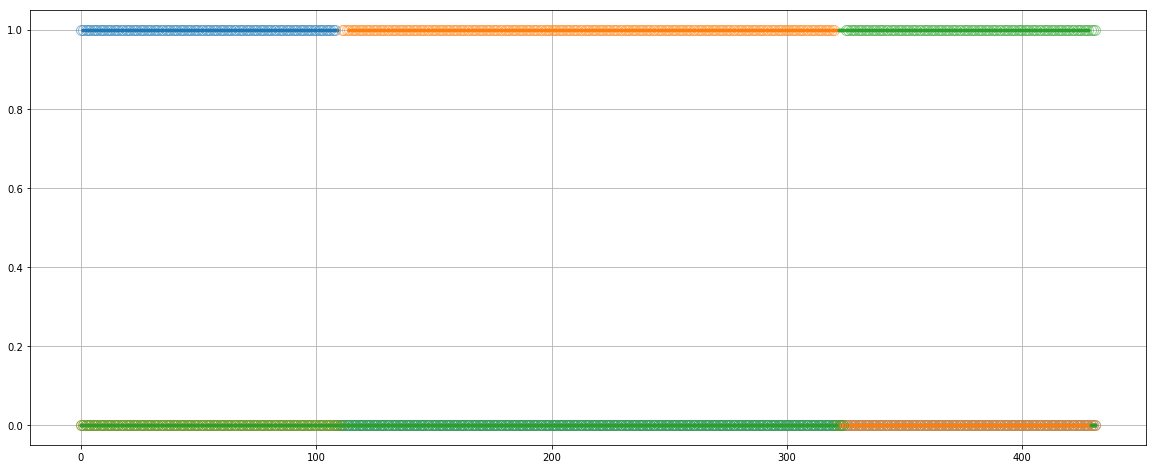

In [49]:
from synthetic_data.trajectory import get_stay_indices, get_adjusted_stays
from sklearn.metrics import precision_score, recall_score, confusion_matrix
    
    
expected_nr_of_stays = int((len(segments)+1)/2)

fig, ax = plt.subplots(figsize=[20,8])
color='C0'

colors = ['C0','C1','C2']

for n in range(0,len(segments),2):
    
    true_indices = get_stay_indices(get_adjusted_stays(segments[n:n+1], time_arr), time_arr)[0]    
    print(n, true_indices[0], true_indices[-1])
    
    nn = int(n/2)
    clust = final_extended_clusters[nn]
    print(nn, clust[0], clust[-1])    
    
    pair = [min(true_indices[0],clust[0]), max(true_indices[-1],clust[-1])]
    print(pair)
    
    true_labels = np.zeros(time_arr.shape)
    true_labels[true_indices[0]:true_indices[1]+1] = 1
        
        
    pred_labels = np.zeros(time_arr.shape)
    pred_labels[clust[0]:clust[-1]+1] = 1      
    
 
    prec = precision_score(true_labels, pred_labels)
    rec  = recall_score(true_labels, pred_labels)        
    
    color = colors[nn]
    ax.plot(true_labels, 'o', markersize=10, color=color, markerfacecolor='None', alpha=0.5)
    ax.plot(pred_labels, '.', color=color)

    print(prec, rec)
    #break

plt.grid()    

In [50]:
from helper__3stays_v3_scripts import get_no_overlap

In [65]:
ultimate_clusters = get_no_overlap(time_arr, final_extended_clusters.copy())

114 321 322 428


In [77]:
get_uniqs = lambda clusts: [print(len(c), len(set(c))) for c in clusts]

In [78]:
_ = get_uniqs(clusters)

110 110
41 41
166 166
2 2
29 29
30 30
39 39


In [79]:
_ = get_uniqs(clusters_rev)

42 42
65 65
80 80
20 20
62 62
20 20
22 22
107 107


In [81]:
_ = get_uniqs(new_clusters)

110 110
209 209
106 106


In [83]:
_ = get_uniqs(new_clusters_rev)

110 110
209 209
106 106


In [82]:
_ = get_uniqs(new_clusters_2)

110 110
209 209
106 106


In [84]:
_ = get_uniqs(new_clusters_rev_2)

110 110
209 209
106 106


In [80]:
_ = get_uniqs(final_clusters)

54 54
103 103
52 52


In [85]:
_ = get_uniqs(final_extended_clusters)

53 52
103 102
52 51


In [76]:
_ = get_uniqs(ultimate_clusters)

53 52
103 102
103 102


(5.5, 18.25)

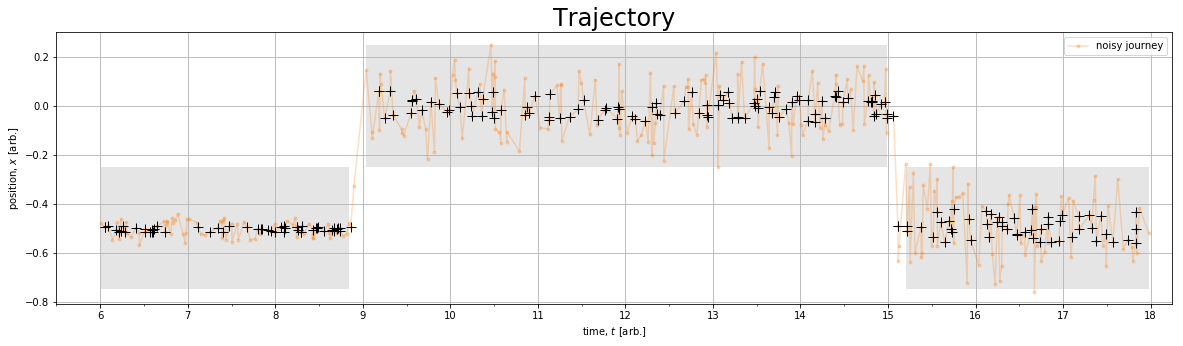

In [54]:
ax = plot_trajectory(time_arr, None, noise_arr, None, None, configs['dist_thresh']);
add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)

for c in final_extended_clusters:

    ax.plot(time_arr[c], noise_arr[c], "k+", markersize=10, markerfacecolor='k')


for c in ultimate_clusters:

    ax.plot(time_arr[c], noise_arr[c], "ko", markersize=4, markerfacecolor='k')

ax.set_xlim([5.5,18.25])
#ax.set_xlim([8.5,15.5]);

In [56]:
prec, rec, conmat = eval_synth_data(segments, time_arr, ultimate_clusters)
print(f"{prec:6.3f}")
print(f"{ rec:6.3f}")
print(conmat)

 0.000
 0.000
[[  6   0]
 [426   0]]


In [57]:
ultimate_clusters

[]